In [ ]:
!pip install keras_vggface
!pip install keras_applications

     |████████████████████████████████| 50 kB 6.8 MB/s 


In [ ]:
import os 
import math   
import matplotlib.pyplot as plt    # for plotting the images
%matplotlib inline
import pandas as pd

import cv2     # Para capturar videos
from keras.preprocessing import image   # for preprocessing the images
import numpy as np    
from keras.utils import np_utils
from skimage.transform import resize   # for resizing images

import tensorflow as tf


import dlib # Extraer rostro
from google.colab.patches import cv2_imshow

In [ ]:
# Establecer conecxión con drive para extraer los datos
from google.colab import drive #Conexión con Drive
drive.mount('/content/drive')
#Ubicación de los datos 
PATH = '/content/drive/MyDrive/Hackaton zinobe/Dataset/yalefaces/'

# lista de archivos de video
dir_list = os.listdir(PATH)

Mounted at /content/drive


<h1 align = 'center' > Análisis de Imagen </h1>

### Carga datos

In [ ]:
import joblib
X = joblib.load('/content/drive/MyDrive/Hackaton zinobe/Dataset/DATOS_PREPROCESADOS_ROSTRO/x.joblib')
y = joblib.load('/content/drive/MyDrive/Hackaton zinobe/Dataset/DATOS_PREPROCESADOS_ROSTRO/y.joblib')

#### Dimensión de los datos

In [ ]:
print('Shape X:',X.shape)
print('Shape y:',y.shape)

Shape X: (12090, 2, 48, 48)
Shape y: (12090,)


### Reshape

In [ ]:
X = X.transpose(0,2,3,1)
print('Shape X:',X.shape)

Shape X: (12090, 48, 48, 2)


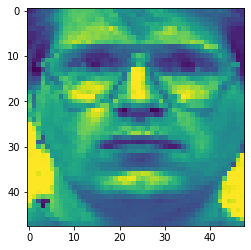

In [ ]:
plt.figure()
plt.imshow(X[0][:,:,0])

RBG 

In [ ]:
X_1 = X[:5000,:,:,0,np.newaxis]
X_2 = X[:5000,:,:,1,np.newaxis]

In [ ]:
print('Forma X_1:',X_1.shape)
print('Forma X_2:',X_2.shape)

Forma X_1: (5000, 224, 224, 3)
Forma X_2: (5000, 224, 224, 3)


In [ ]:
X_1 = tf.image.grayscale_to_rgb(tf.convert_to_tensor(X_1))
X_2 = tf.image.grayscale_to_rgb(tf.convert_to_tensor(X_2))

In [ ]:
X_1 = tf.image.resize(X_1,[224,224])

In [ ]:
X_2 = tf.image.resize(X_2,[224,224])

In [ ]:
print(X_1.shape)
print(X_2.shape)

(5000, 224, 224, 3)
(5000, 224, 224, 3)


### Incrustación 

In [ ]:
from scipy.spatial.distance import cosine
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input

In [ ]:
model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
yhat_1_VGGFace = model.predict(X_1)
yhat_2_VGGFace = model.predict(X_2)

In [ ]:
from keras.applications.vgg19 import VGG19

In [ ]:
model_VGG19 = VGG19( include_top=False, input_shape=(224, 224, 3), pooling='avg')
yhat_1_VGG19 = model.predict(X_1[:1000])
yhat_2_VGG19 = model.predict(X_2[:1000])

80150528/80134624 [==============================] - 1s 0us/step


#### Calculo de diferencias

In [ ]:
from scipy import spatial
def is_match(y_1,y_2,cutoff = 0.5):
  sim = list()
  for y__1, y__2 in list(zip(y_1,y_2)):
    sim.append(1 - spatial.distance.cosine(y__1,y__2))
  return sim  

In [ ]:
yhat_VGGFace = is_match(yhat_1_VGGFace,yhat_2_VGGFace)

In [ ]:
yhat_VGG19 = is_match(yhat_1_VGG19,yhat_2_VGG19)

### Evaluación predicción 
* AUC y Curva ROC 

In [ ]:
from sklearn.metrics import roc_curve, auc

yhat_ = yhat # Cambiar de acuerdo al modelo que se quiere validar 
fpr = dict()
tpr = dict()
n_classes = 2
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:1000], yhat_)
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y[:1000], yhat_)
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

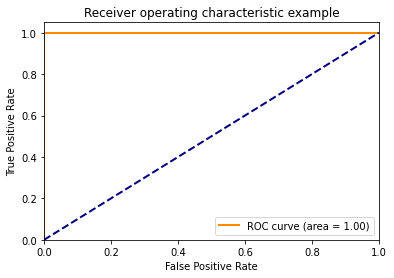

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

* Matriz de Confusión

In [ ]:
from sklearn.metrics import confusion_matrix #matriz de confusión

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
dic  =  {0:'Correcto', 1:'Alerta'}
y_t = [dic[letter] for letter in y[:1000]]
y_hat = np.array(yhat_) > 0.6
y_hat = [dic[letter] for letter in y_hat ]
cmat = confusion_matrix(y_t, y_hat, labels = list(dic.values()))

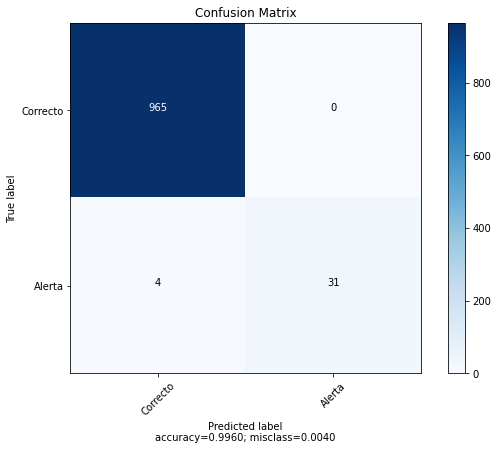

In [ ]:
import itertools    

plot_confusion_matrix(cm = cmat, 
normalize = False,
target_names = list(dic.values()),
title = "Confusion Matrix")